In [242]:
from enum import Enum
from typing import List, Tuple
from collections import Counter, OrderedDict
from itertools import combinations, product
import operator

In [183]:
DICE_PER_ROLL = 5
DICE_VALUES = [1,2,3,4,5,6]
INDENT = 22

In [184]:
def sum_of_single_value(input_list: Tuple[int], value: int):
    return input_list.count(value) * value

In [185]:
def n_of_a_kind(input_list: Tuple[int], n: int):
    for value, count in Counter(input_list).items():
        if count >= n:
            if n == DICE_PER_ROLL:
                return 50
            else:
                return sum(input_list)
    return 0

In [186]:
def full_house(input_list: Tuple[int]):
    if set(Counter(input_list).values()) == {3, 2}:
        return 25
    else:
        return 0

In [187]:
def find_longest_sequence(input_list: Tuple[int]):
    max_seq = 1
    nums = set(input_list)
    for num in nums:
        this_seq = 1
        seq = True
        while seq:
            if num + this_seq in nums:
                this_seq += 1
            else:
                seq = False
        
        max_seq = max(this_seq, max_seq)
    
    return max_seq

In [188]:
def straight(input_list: Tuple[int], size: int):
    seq = find_longest_sequence(input_list)
    
    if seq >= size:
        if size == DICE_PER_ROLL:
            return 40
        elif size == DICE_PER_ROLL - 1:
            return 30
        
    return 0

In [244]:
hand_scoring_functions = [
    lambda x: sum_of_single_value(x, 1),
    lambda x: sum_of_single_value(x, 2),
    lambda x: sum_of_single_value(x, 3),
    lambda x: sum_of_single_value(x, 4),
    lambda x: sum_of_single_value(x, 5),
    lambda x: sum_of_single_value(x, 6),
    lambda x: n_of_a_kind(x, 3),
    lambda x: n_of_a_kind(x, 4),
    lambda x: full_house(x),
    lambda x: straight(x, 4),
    lambda x: straight(x, 5),
    lambda x: n_of_a_kind(x, 5),
    lambda x: sum(x)
]

hand_scoring_names = [
    "ONES",
    "TWOS",
    "THREES",
    "FOURS",
    "FIVES",
    "SIXES",
    "THREE OF A KIND",
    "FOUR OF A KIND",
    "FULL HOUSE",
    "SMALL STRAIGHT",
    "LARGE STRAIGHT",
    "YAHTZEE",
    "CHANCE"
]

In [190]:
def calculate_hand_scores(roll: Tuple[int], debug: bool = False):
    hand_scores = [func(roll) for func in hand_scoring_functions]
    if debug:
        print(f'{"all hand scores:":>{INDENT}} {hand_scores}')
    return hand_scores

In [247]:
def calc_max_score(roll: Tuple[int], debug: bool = False):
    max_index, max_value = max(enumerate(calculate_hand_scores(roll, debug=debug)[::-1]),
                               key=operator.itemgetter(1))
    
    if debug:
        print(f'{"max roll score:":>{INDENT}} {max_value}')
        print(f'{"catgeory:":>{INDENT}} {hand_scoring_names[::-1][max_index]}')
    return max_value

In [235]:
def all_possible_final_hands(saved_dice: Tuple[int], debug: bool = False):
    number_of_rerolls = DICE_PER_ROLL - len(saved_dice)
    possible_reroll_outcomes = []
    
    for reroll in product(DICE_VALUES, repeat=number_of_rerolls):
        hand = tuple(saved_dice + tuple(sorted(reroll)))
        possible_reroll_outcomes.append(hand)
    
    return Counter(possible_reroll_outcomes)

In [258]:
def calculate_expected_score(saved_dice: Tuple[int], debug: bool = False):
    final_rolls = all_possible_final_hands(saved_dice, debug=debug)
    number_of_final_hands = sum(final_rolls.values())
    running_expected_score = 0
    running_probability = 0
    
    if debug:
        print(f'{"total rerolled hands:":>{INDENT}} {number_of_final_hands}')
        print()
    
    for roll, count in final_rolls.items():
        if debug:
            print(f'{"possible roll:":>{INDENT}} {roll}')
            print(f'{"count:":>{INDENT}} {count}')
        this_max_score = calc_max_score(roll, debug=debug)
        chance_of_roll = (count/number_of_final_hands)
        expected_score = this_max_score * chance_of_roll
                                        
        if debug:
            print(f'{"chance of roll :":>{INDENT}} {chance_of_roll*100:.2f}')
            print(f'{"expected contrib :":>{INDENT}} {chance_of_roll*100:.2f}')
            print()
        running_expected_score += expected_score
        running_probability += chance_of_roll
    
    if debug:
        print(f'{"total expected :":>{INDENT}} {running_expected_score:.2f}')
        print(f'{"sum of chances :":>{INDENT}} {running_probability*100:.2f}')
        
    return running_expected_score

In [252]:
def calculate_all_save_possibilities(input_list: Tuple[int], debug: bool = False):
    saved_dice = {tuple(), }
    for i in range(1, len(input_list)+1):
        for combo in combinations(input_list, i):
            saved_dice.add(tuple(sorted(combo)))
            
    return saved_dice

In [298]:
def simulate(second_to_last_roll: Tuple[int], debug: bool = False):
    result = dict()
    
    for saved_dice in calculate_all_save_possibilities(second_to_last_roll, debug=debug):
        if debug: print(f'{"saved dice:":>{INDENT}} {saved_dice}')
        result[saved_dice] = calculate_expected_score(saved_dice, debug=debug)
        if debug: print()
    
    
        
    #print(f'{"saved_dice":<18}score')
    #for (saved_roll, expected) in sorted(result.items(), key=lambda x: x[1]):
    #    print(f'{str(saved_roll):<18}{expected:.2f}')
        
    return {k:v for k,v in sorted(result.items(), key=lambda x: -x[1])}

In [299]:
results = simulate((4,4,4,5,5), debug=False)

In [300]:
from matplotlib import pyplot as plt

In [346]:
def plot_reroll_expecteds(results):
    fig, ax = plt.subplots(figsize=(10,6))
    bar_locs = list(range(len(results.values())))
    ax.barh(bar_locs,
            results.values(),
            tick_label=[' '.join(map(str,k)) for k in results.keys()],
            height=1,
           edgecolor='k')
    ax.set_title('expected score for combinations of saved dice')
    ax.set_xlabel('expected score')
    ax.set_ylabel('dice saved after second roll')
    ax.set_ylim(min(bar_locs)-0.5, max(bar_locs)+0.5)
    #ax.set_xlim(18, 26)
    plt.show()

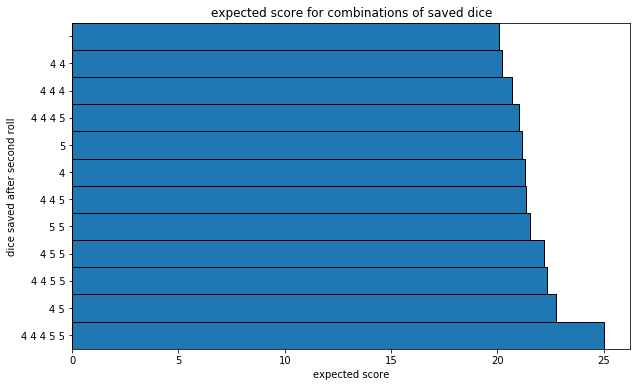

In [347]:
plot_reroll_expecteds(results)